# Transformer Architecture

    Transformers are based on the "Attention is All You Need" paper by Vaswani et al.  

https://arxiv.org/abs/1706.03762

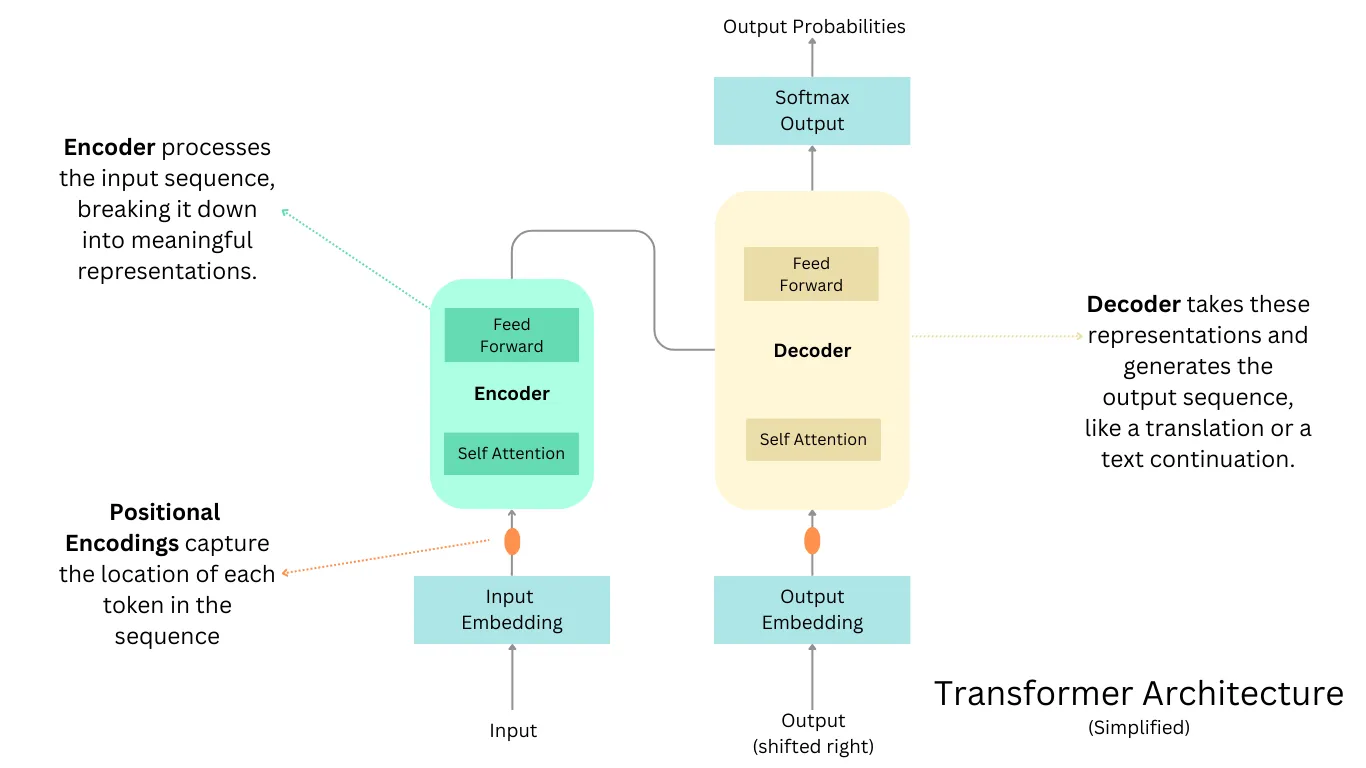 

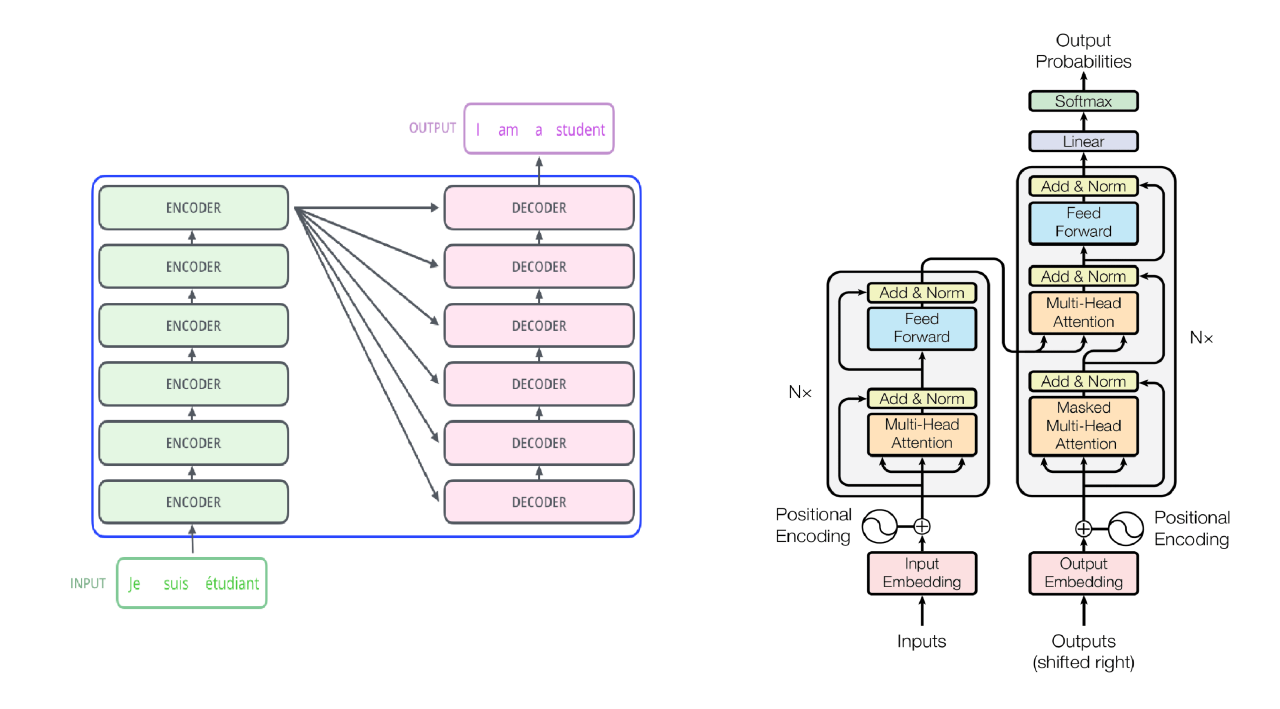

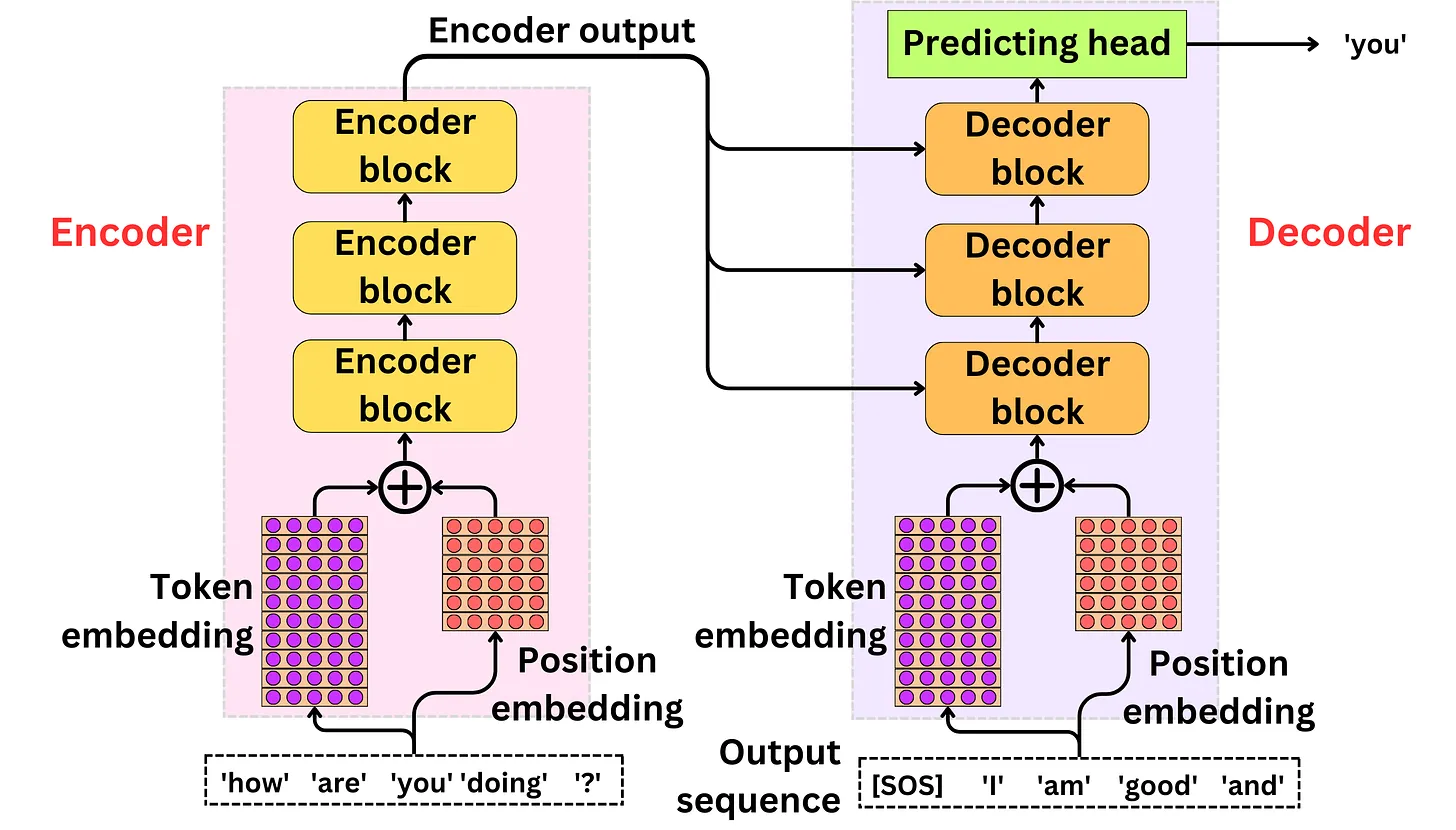

https://medium.com/@reyhaneh.esmailbeigi/bert-gpt-and-bart-a-short-comparison-5d6a57175fca
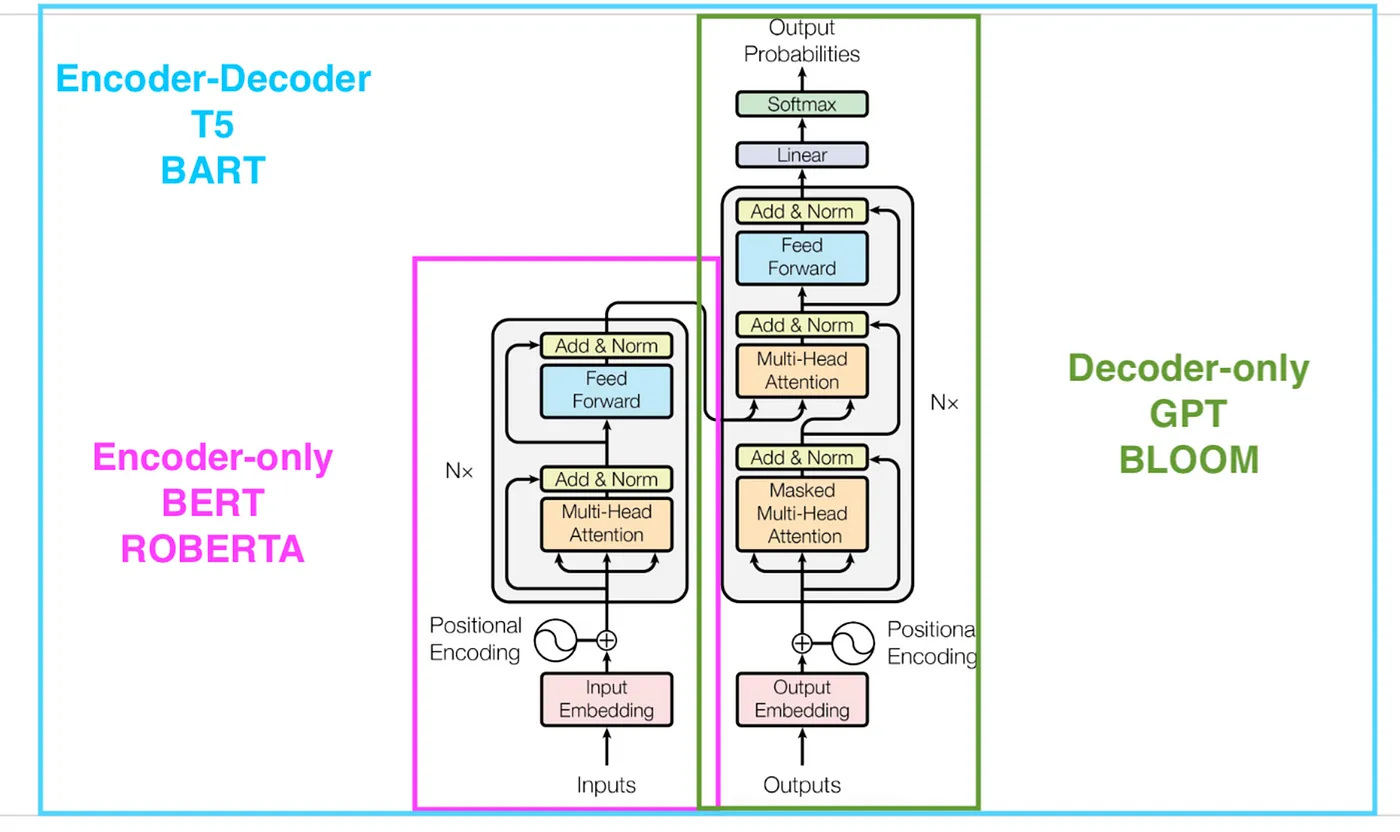 
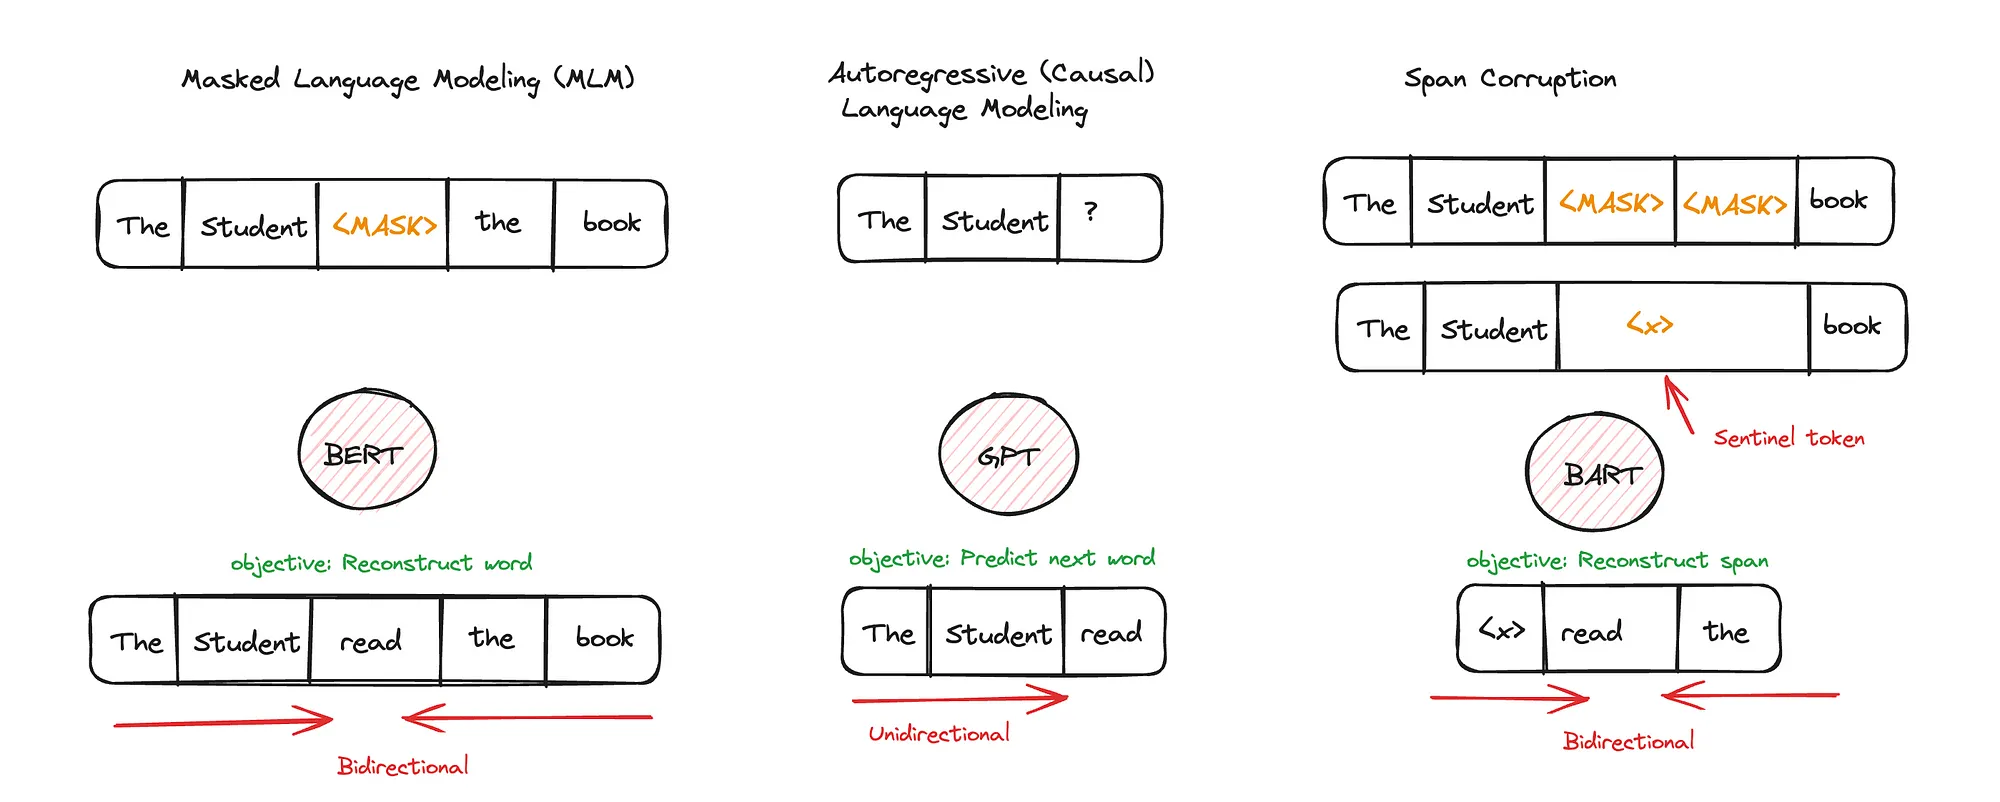
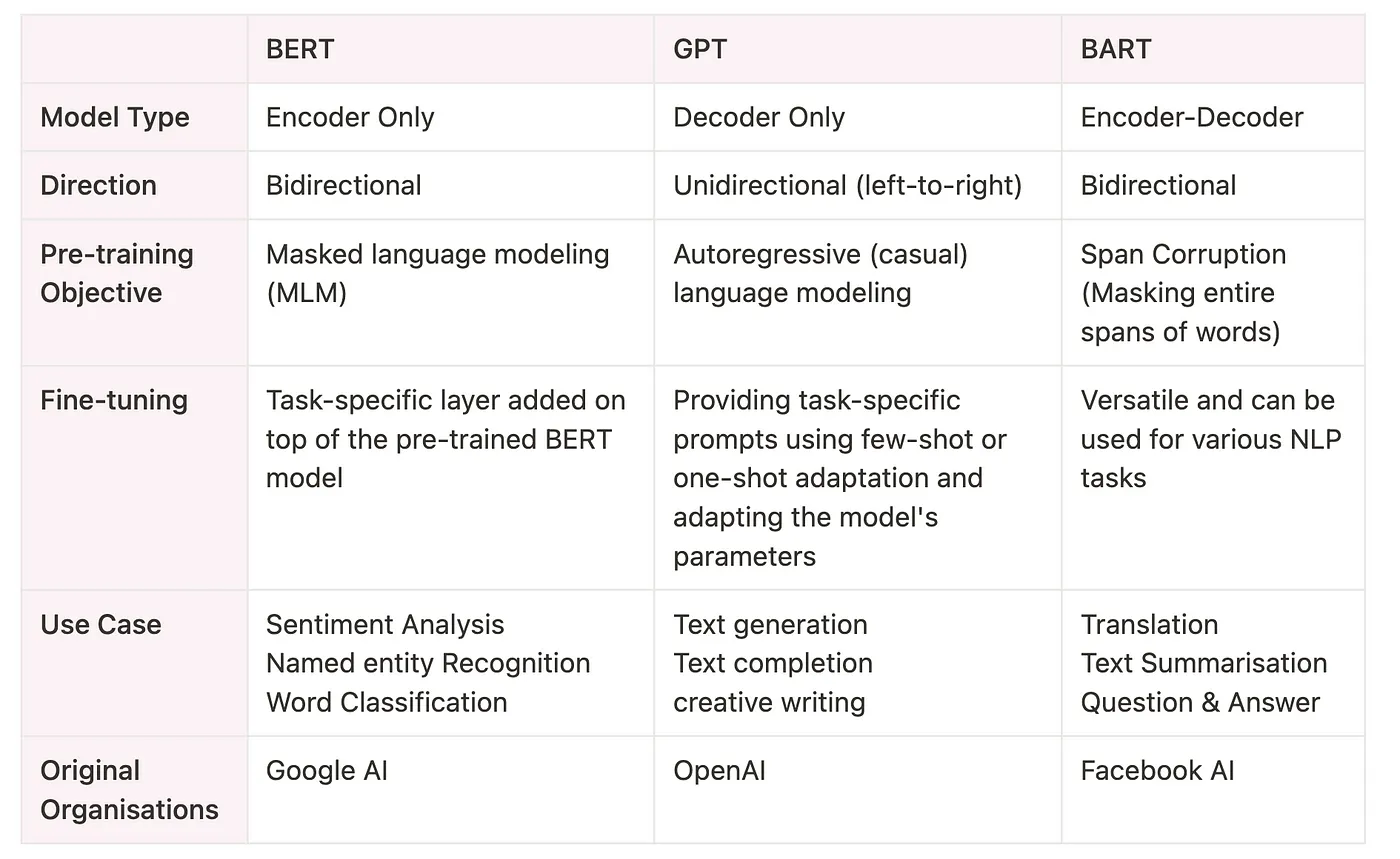


### 1. Encoder-Only Transformer

**Description**: An encoder-only Transformer consists of multiple encoder layers and is trained to understand the entire input sequence, capturing its structure, context, and relationships between tokens.

- **Components**: 
  - Multiple encoder layers.
  - Positional encoding to keep track of token positions.
  - Self-attention to capture relationships between all tokens in the sequence.

- **Use Cases**:
  - **Language Understanding Tasks**: Encoder-only models are ideal for tasks where we need a full understanding of a single sequence, such as:
    - **Text classification** (e.g., sentiment analysis, spam detection).
    - **Named Entity Recognition (NER)**.
    - **Question answering** (if framed as reading comprehension).
    - **Masked Language Modeling** (e.g., BERT), where tokens are masked and the model predicts these tokens based on the surrounding context.
  
- **Examples**: BERT, RoBERTa, and ALBERT are popular encoder-only architectures.

---

### 2. Decoder-Only Transformer

**Description**: A decoder-only Transformer uses only the decoder layers and is designed to generate text by predicting one token at a time based on the previous tokens. It does not have access to the entire input sequence from the start, as this would interfere with autoregressive generation.

- **Components**:
  - Multiple decoder layers.
  - Positional encoding.
  - **Masked self-attention**: Each token can only attend to itself and previous tokens (not future tokens), enabling autoregressive generation.
  
- **Use Cases**:
  - **Text Generation Tasks**: These models are suited for generating text based on a prompt, including:
    - **Language Modeling** (predicting the next token given previous tokens).
    - **Open-ended text generation** (e.g., story generation, dialogue generation).
    - **Code generation** (e.g., models that generate code from a partial input).

- **Examples**: GPT, GPT-2, and GPT-3 are popular decoder-only models.

---

### 3. Encoder-Decoder Transformer

**Description**: An encoder-decoder Transformer, also known as a sequence-to-sequence model, uses both an encoder and a decoder. The encoder processes the input sequence, creating a representation that the decoder then uses to generate a target sequence.

- **Components**:
  - Encoder layers to process the input sequence.
  - Decoder layers to generate the target sequence based on the encoder’s output.
  - **Cross-attention** in the decoder: The decoder attends to both its own previous tokens (via masked self-attention) and the encoder’s output (via cross-attention), which allows it to use information from the entire input sequence.

- **Use Cases**:
  - **Sequence-to-Sequence Tasks**: Encoder-decoder models are suitable for tasks where we need to transform one sequence into another, such as:
    - **Machine Translation** (e.g., translating English to French).
    - **Summarization** (generating a shorter version of the input text).
    - **Text-to-Text generation** (e.g., question answering where the answer is generated as a separate sequence).
    - **Image Captioning** (encoder processes an image, decoder generates a caption).

- **Examples**: T5, BART, and MarianMT are examples of encoder-decoder models.

---

### Summary Comparison

| Architecture      | Components Used         | Self-Attention Type  | Typical Use Cases                                 | Example Models               |
|-------------------|-------------------------|----------------------|--------------------------------------------------|-------------------------------|
| Encoder-Only      | Encoder Layers          | Full Self-Attention  | Language understanding, classification, NER      | BERT, RoBERTa, ALBERT         |
| Decoder-Only      | Decoder Layers          | Masked Self-Attention| Text generation, language modeling               | GPT, GPT-2, GPT-3             |
| Encoder-Decoder   | Encoder + Decoder Layers| Cross-Attention      | Sequence-to-sequence, translation, summarization | T5, BART, MarianMT            |

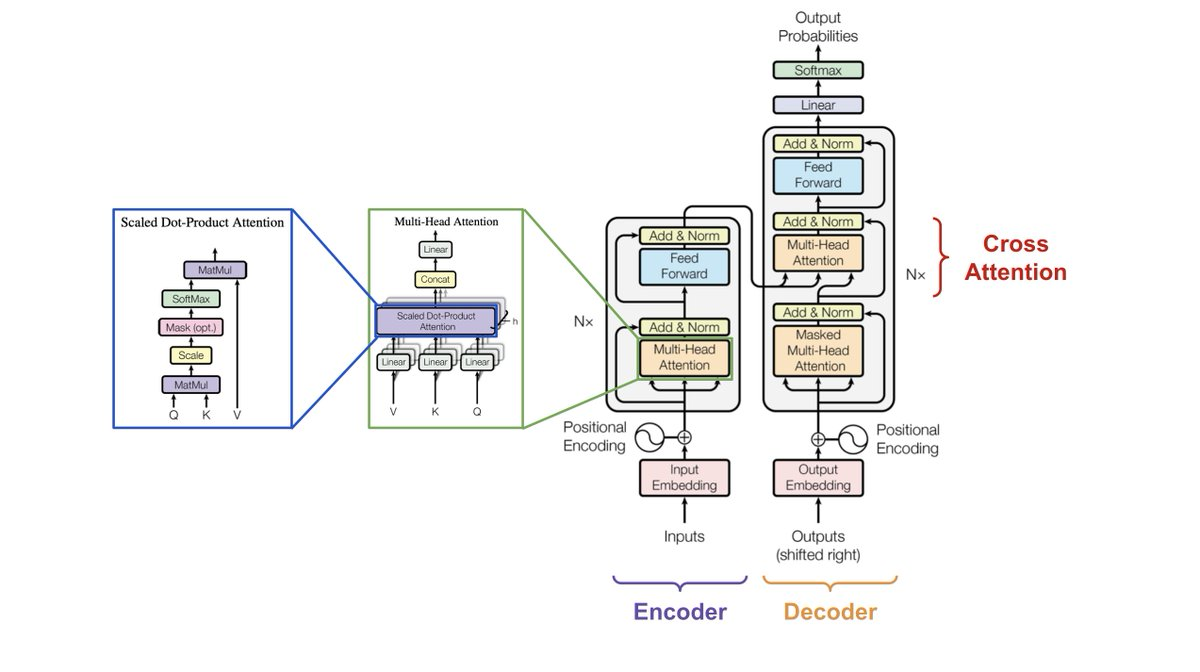 

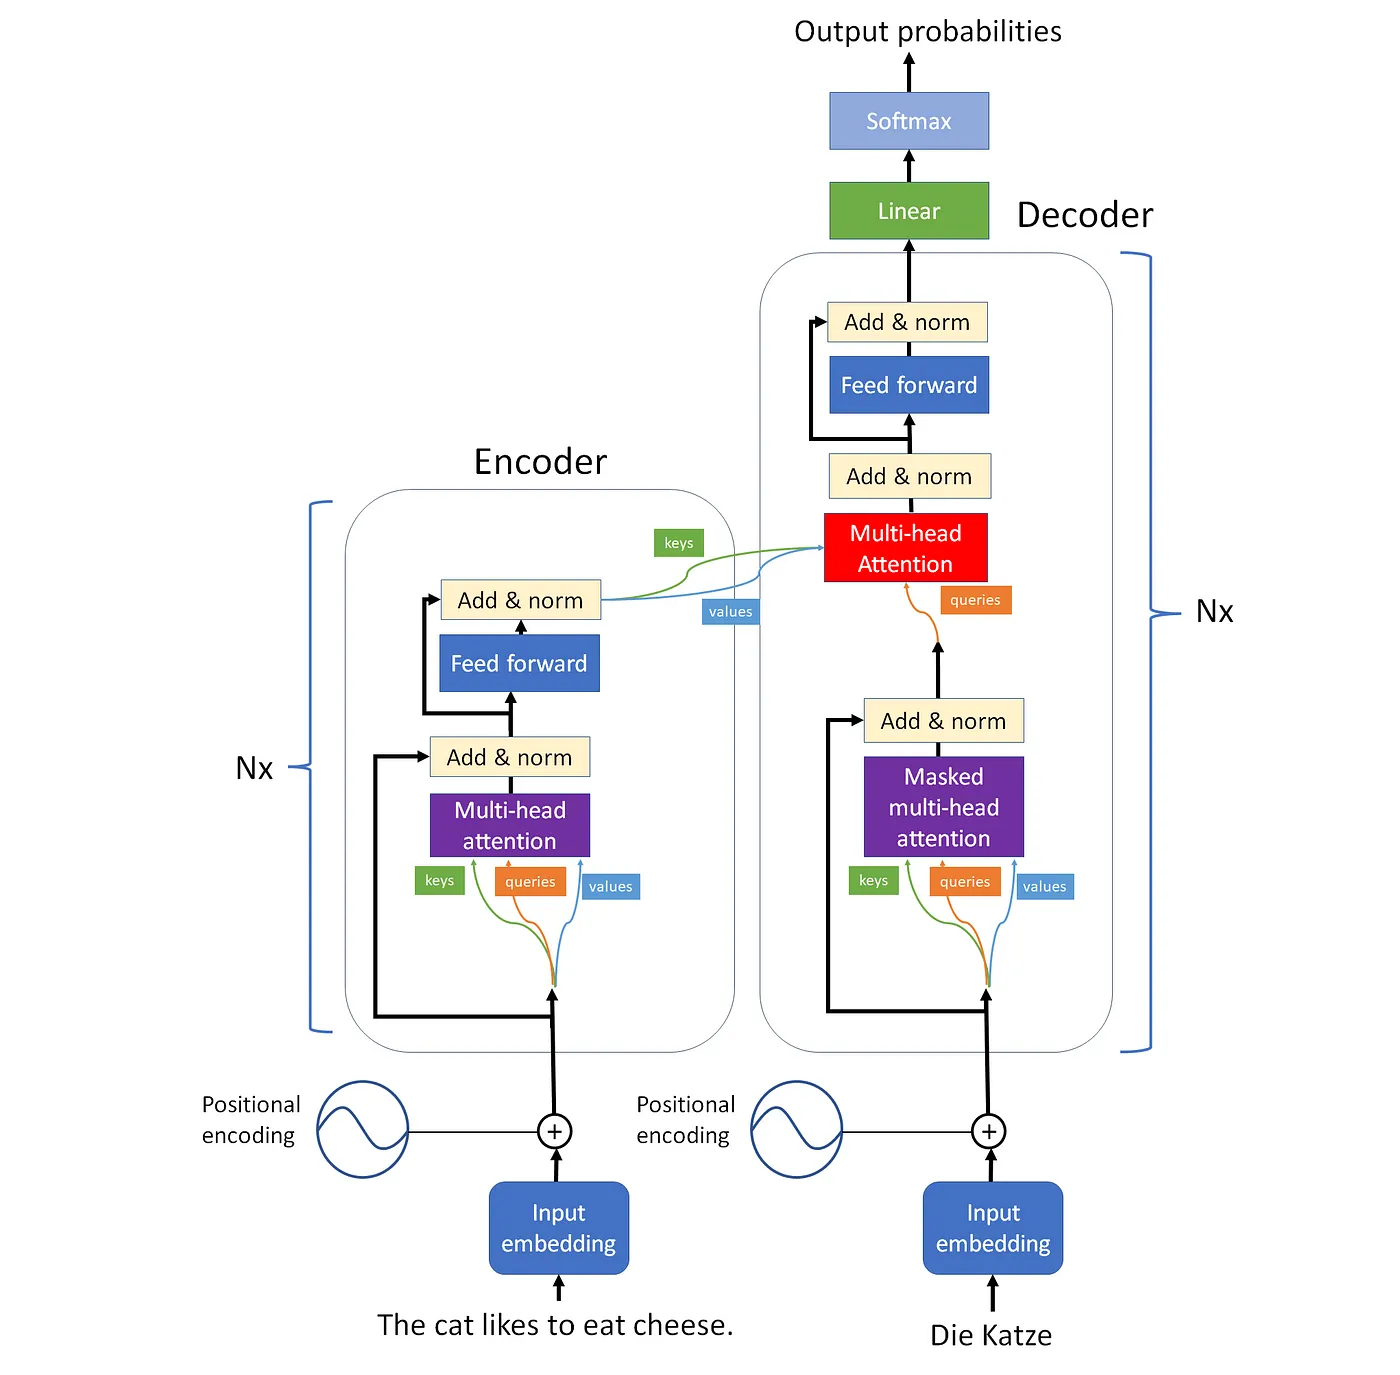 

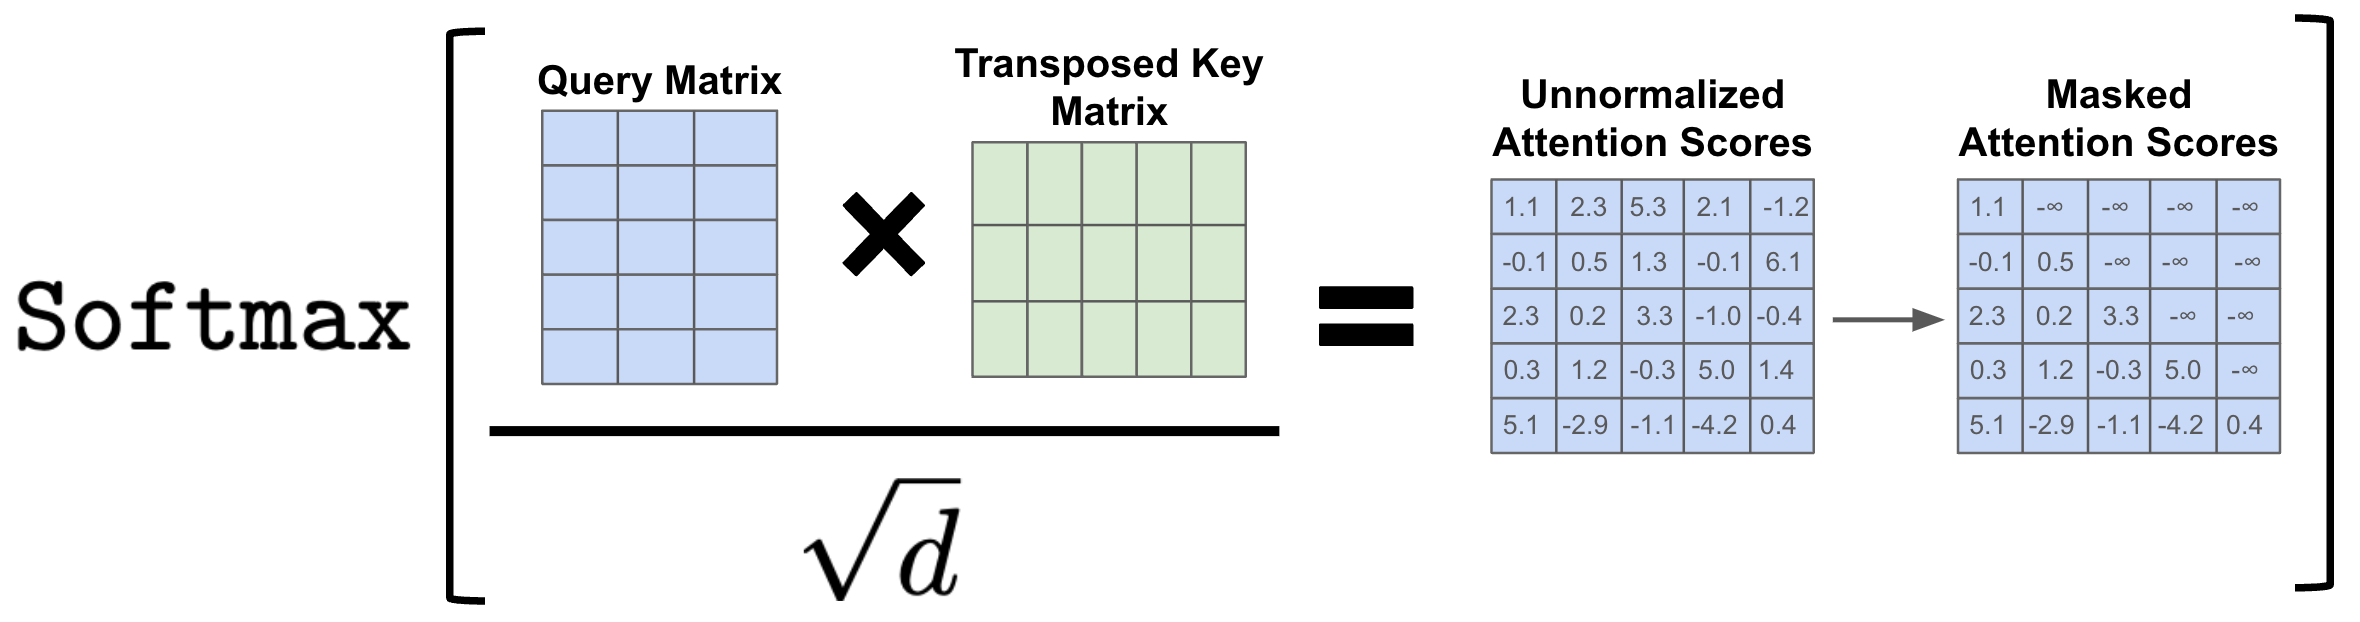 

In [8]:
# !pip install transformers

In [9]:
import torch
from torch import nn
import torch.optim as optim
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import os


/Users/mani/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Load text data and prepare the dataset
with open('ali_karimi.txt', 'r', encoding='utf-8') as f:
    ali_karimi_text = f.read()

In [11]:
# Dataset Class for Language Modeling
class WordDataset(Dataset):
    def __init__(self, text, seq_length, tokenizer):
        self.seq_length = min(seq_length, MAX_SEQ_LENGTH)  # Limit to MAX_SEQ_LENGTH
        self.tokenizer = tokenizer
        self.tokens = self.tokenizer(text, truncation=True, max_length=MAX_SEQ_LENGTH)['input_ids']  # Tokenize with truncation
        self.vocab_size = len(self.tokenizer.get_vocab())
        self.data = self.tokens

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_length]
        target = self.data[idx + 1:idx + self.seq_length + 1]
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)


In [12]:
# Set max length to the model's limit
MAX_SEQ_LENGTH = 512

In [13]:
# Load tokenizer and data
tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-fa-zwnj-base')


seq_length = 50
dataset = WordDataset(ali_karimi_text, seq_length, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# TransformerEncoder
https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html

    nn.TransformerEncoder(encoder_layer, num_layers, norm=None, enable_nested_tensor=True, mask_check=True)

> Parameters
> - encoder_layer (TransformerEncoderLayer) – an instance of the TransformerEncoderLayer() class (required).
> - num_layers (int) – the number of sub-encoder-layers in the encoder (required).
> - norm (Optional[Module]) – the layer normalization component (optional).
> - enable_nested_tensor (bool) – if True, input will automatically convert to nested tensor (and convert back on output). This will improve the overall performance of TransformerEncoder when padding rate is high. Default: True (enabled).


### TransformerEncoderLayer

    nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=<function relu>, layer_norm_eps=1e-05, batch_first=False, norm_first=False, bias=True, device=None, dtype=None)
    
> Parameters
> - d_model (int) – the number of expected features in the input (required).
> - nhead (int) – the number of heads in the multiheadattention models (required).
> - dim_feedforward (int) – the dimension of the feedforward network model (default=2048).
> - dropout (float) – the dropout value (default=0.1).

In [16]:

# Transformer Model Class for Text Generation
class TransformerEncoderOnlyModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, nhid, nlayers, seq_length, dropout=0.5):
        super(TransformerEncoderOnlyModel, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length  # Added seq_length as an attribute

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, nhid, dropout, batch_first=True)  # Set batch_first=True
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        # Embedding layer for input tokens
        self.encoder = nn.Embedding(ntoken, d_model)
        
        # Output linear layer to project hidden states to vocabulary size
        self.decoder = nn.Linear(d_model, ntoken)
        
        # Initialize weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Embed the source tokens
        src = self.encoder(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32)).to(src.device)
        
        # Apply positional encoding
        src = self.pos_encoder(src)
        
        # Transformer encoder
        output = self.transformer_encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        # Decoder
        output = self.decoder(output)
        return output


# Text Generation Function
def generate_text(model, tokenizer, start_text, max_len=50, temperature=1.0):
    model.eval()
    tokens = tokenizer(start_text, return_tensors='pt')['input_ids']
    tokens = tokens.squeeze(0)

    generated_tokens = tokens.tolist()

    for _ in range(max_len):
        input_tensor = torch.tensor(generated_tokens[-model.seq_length:], device=next(model.parameters()).device).unsqueeze(1)
        with torch.no_grad():
            output = model(input_tensor)
        
        # Get the logits for the last token and apply temperature
        logits = output[-1, :].squeeze() / temperature
        probabilities = torch.softmax(logits, dim=0)
        
        # Sample from the distribution
        next_token = torch.multinomial(probabilities, 1).item()
        generated_tokens.append(next_token)

        # Stop if end-of-sequence token is generated
        if next_token == tokenizer.eos_token_id:
            break

    # Decode the generated tokens back to text
    return tokenizer.decode(generated_tokens, skip_special_tokens=True)


# Training Function with Learning Rate Scheduler
def train_encoder_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(inputs)
            
            # Reshape output and targets for loss calculation
            output = output.view(-1, output.size(-1))
            targets = targets.view(-1)
            
            # Calculate loss
            loss = criterion(output, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Update learning rate scheduler
        scheduler.step()

        # Print average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        # Generate sample
        if (epoch + 1) % 10 == 0:
            start_text = "علی کریمی یکی از بهترین بازیکنان"
            generated_text = generate_text(model, tokenizer, start_text, max_len=100, temperature=0.8)
            print(f"\nGenerated Text after Epoch {epoch + 1}:\n{generated_text}\n")

    # Save the model at the end
    torch.save(model.state_dict(), "TransformerEncoderOnlyModel.pth")


In [17]:


# Initialize model
ntoken = dataset.vocab_size  # Number of unique tokens
d_model = 512                # Embedding size
nhead = 8                    # Number of attention heads
nhid = 512                   # Feedforward network dimension
nlayers = 6                  # Number of transformer encoder layers
dropout = 0.2                # Dropout rate


model = TransformerEncoderOnlyModel(ntoken, d_model, nhead, nhid, nlayers, seq_length, dropout).to(device)
# Define loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)  # Decay LR every 2 epochs


# Train the model
train_encoder_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=30)

# Save the trained model
model_path = 'TransformerEncoderOnlyModel.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Generate text
start_text = "علی کریمی یکی از بهترین بازیکنان"
generated_text = generate_text(model, tokenizer, start_text, max_len=100, temperature=0.8)
print(generated_text)


Epoch [1/30], Loss: 6.7515, LR: 0.001000
Epoch [2/30], Loss: 4.8087, LR: 0.000900
Epoch [3/30], Loss: 4.8003, LR: 0.000900
Epoch [4/30], Loss: 4.7649, LR: 0.000810
Epoch [5/30], Loss: 4.6406, LR: 0.000810
Epoch [6/30], Loss: 3.9818, LR: 0.000729
Epoch [7/30], Loss: 1.6514, LR: 0.000729
Epoch [8/30], Loss: 0.6688, LR: 0.000656
Epoch [9/30], Loss: 0.4561, LR: 0.000656
Epoch [10/30], Loss: 0.3827, LR: 0.000590

Generated Text after Epoch 10:
علی کریمی یکی از بهترین بازیکنان مسابقات علاء ( ( ( ۲۰۰۴ گل ۲۰۰۴ مقام اهل از ویدیو سوی جهانی ۲۰۱۸ نیز ، قطر ، ، قطر ، ، قطر خود را ایران ایران انتخاب بود. او ایران حرفه ۳ ۳ویخت ، ، ، قطر [ شناخته ساز سال ۲ ۲ ۲ ۲ ۲ ۲ ۲ ۲ ۲ ۲ ۲ ۲ ۲ ۱۳۷۵ بازی زن به پایان بازگشت محروم می که کریمی ۱۳۹۴ ، قطر ، قطر ، ، قطر [ ۴ خود خود را کسب کسبل مقام سوم هم زن ۶ کنفدراسیون کنفدراسیون کنفدراسیون باشگاه مسابقات

Epoch [11/30], Loss: 0.2469, LR: 0.000590
Epoch [12/30], Loss: 0.1663, LR: 0.000531
Epoch [13/30], Loss: 0.1060, LR: 0.000531
Epoch [14/30], Loss: 0.0731, LR: 0.0004

---

# Decoder-Only Transformer:
- Decoder-Only Transformer: Replaced TransformerEncoder with TransformerDecoder.
- Autoregressive Masking: Added square subsequent mask for preventing the decoder from attending to future tokens.
- Memory Removed: No memory is passed to the decoder since this is an autoregressive generation task.
- Custom Methods: The generate_square_subsequent_mask method creates the masks needed for decoding.

> ## Masked Attention
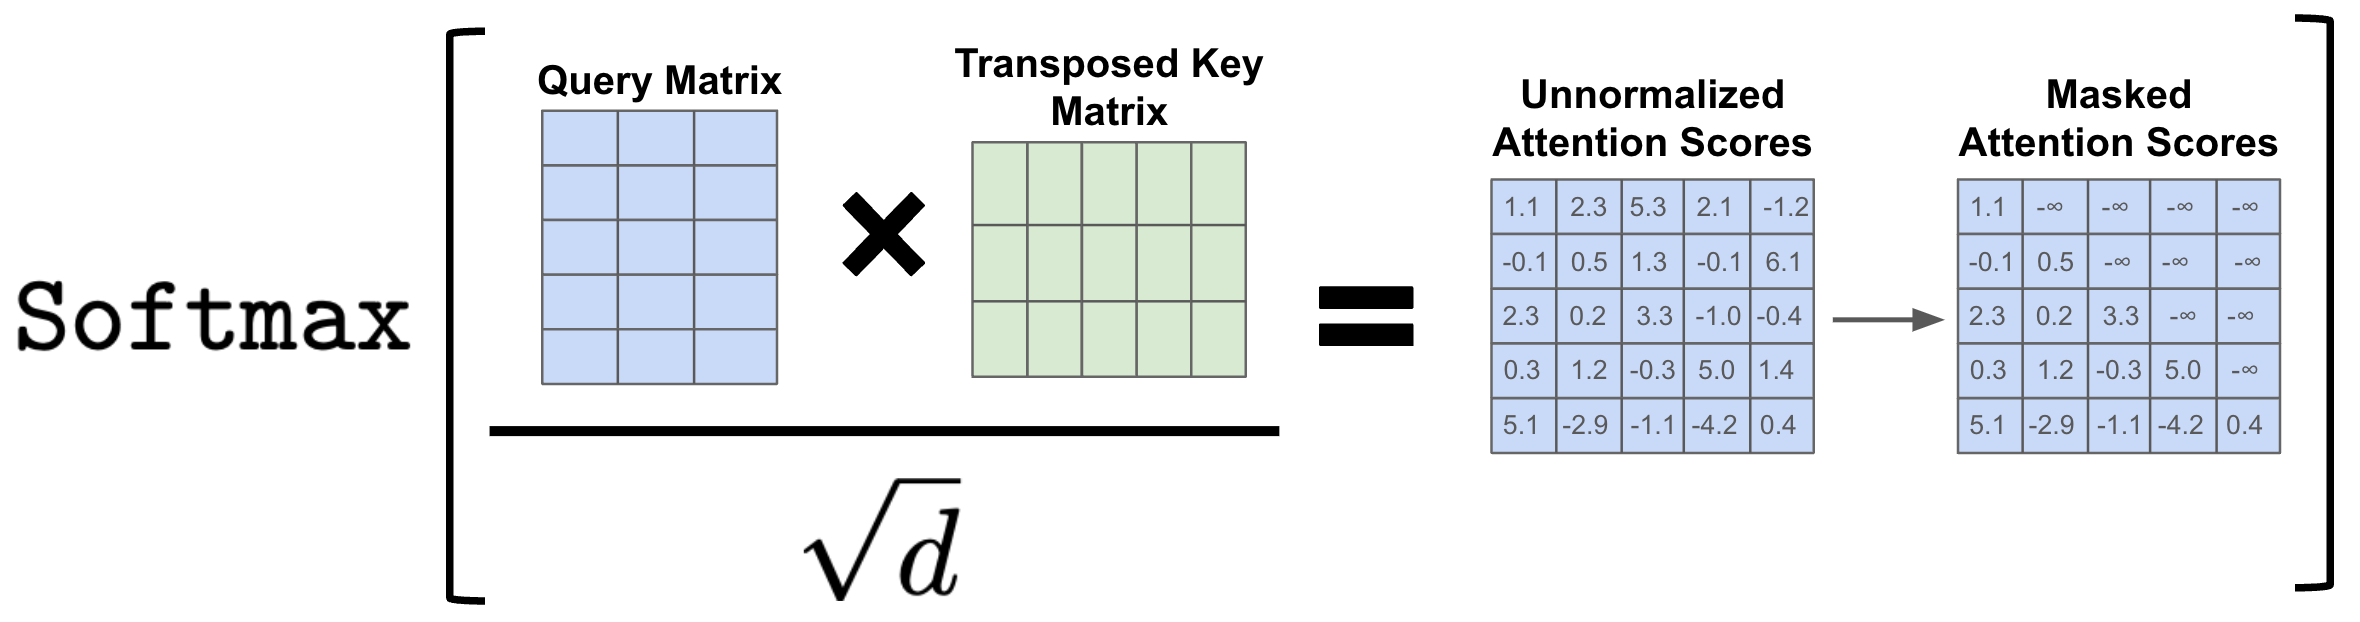 
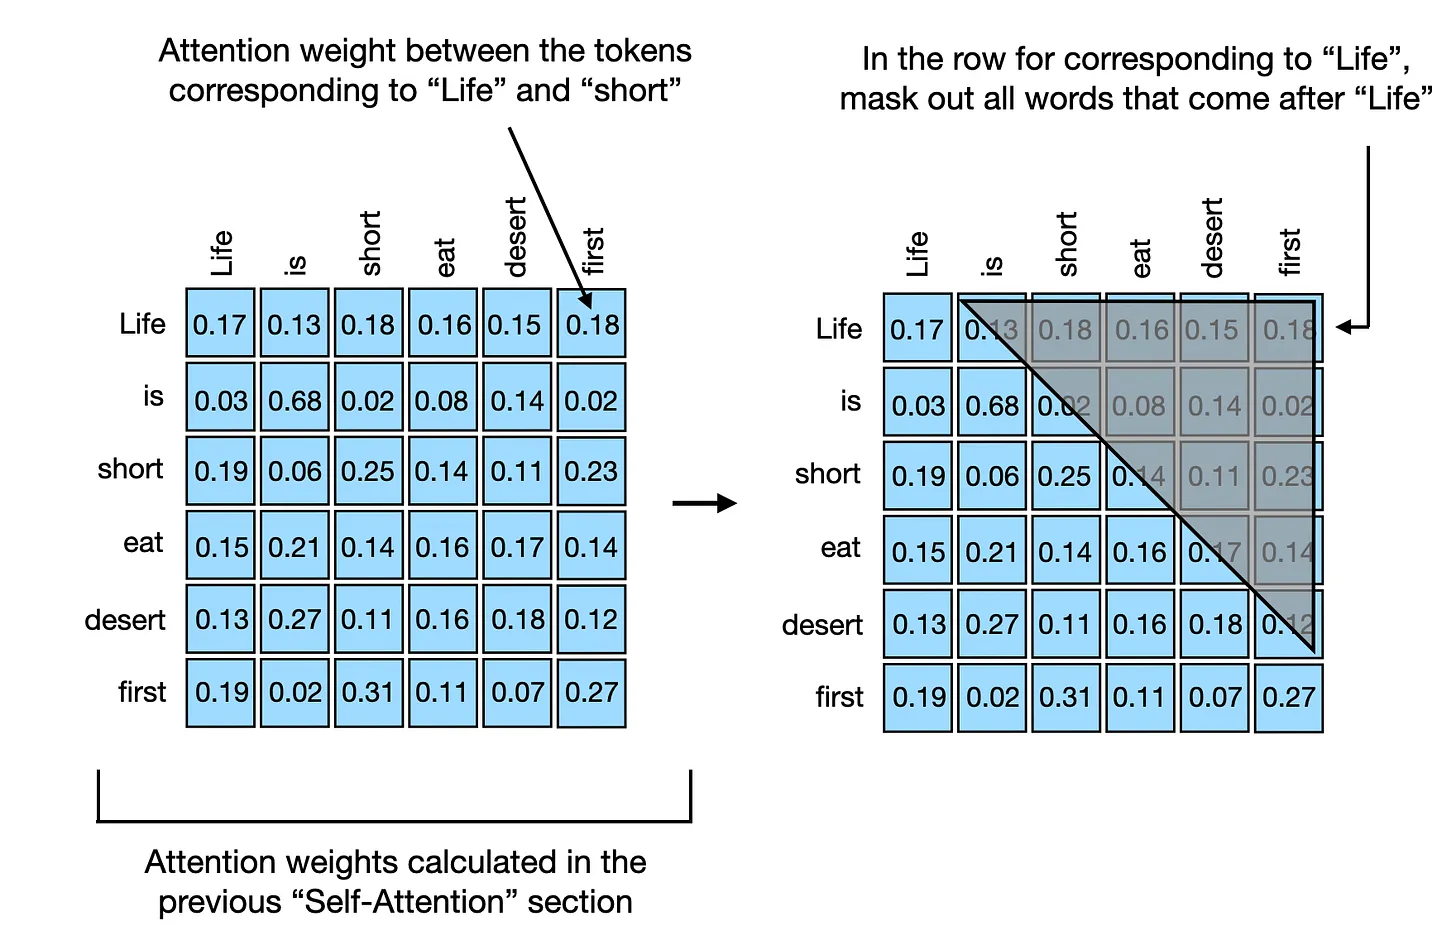

# TransformerDecoder
https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html

    TransformerDecoder is a stack of N decoder layers.

      torch.nn.TransformerDecoder(decoder_layer, num_layers, norm=None)
> 
> Parameters
> - decoder_layer (TransformerDecoderLayer) – an instance of the TransformerDecoderLayer() class (required).
> - num_layers (int) – the number of sub-decoder-layers in the decoder (required).
> - norm (Optional) – the layer normalization component (optional).
 
### TransformerDecoderLayer
    
    torch.nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=<function relu>, layer_norm_eps=1e-05, batch_first=False, norm_first=False, bias=True, device=None, dtype=None)
> 
> Parameters
> - d_model (int) – the number of expected features in the input (required).
> - nhead (int) – the number of heads in the multiheadattention models (required).
> - dim_feedforward (int) – the dimension of the feedforward network model (default=2048).
> - dropout (float) – the dropout value (default=0.1).

In [21]:
class TransformerDecoderOnlyModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, nhid, nlayers, seq_length, dropout=0.5):
        super(TransformerDecoderOnlyModel, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        # Embedding layer for input tokens
        self.embedding = nn.Embedding(ntoken, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        # Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, nhid, dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, nlayers)

        # Output linear layer to project hidden states to vocabulary size
        self.output_projection = nn.Linear(d_model, ntoken)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)

    def forward(self, tgt, tgt_mask=None, tgt_key_padding_mask=None):
        # Embed target tokens
        tgt = self.embedding(tgt) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32)).to(tgt.device)

        # Apply positional encoding
        tgt = self.positional_encoding(tgt)

        # Use tgt as memory for decoder-only setup
        output = self.decoder(
            tgt=tgt,
            memory=tgt,  # Reuse `tgt` as `memory` in decoder-only configuration
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        # Project to vocabulary size
        output = self.output_projection(output)
        return output

    @staticmethod
    def generate_square_subsequent_mask(sz):
        """
        Generate a square mask for the sequence to prevent attention to future positions.
        """
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        return mask.masked_fill(mask == 1, float('-inf'))

# Training Function
def train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for tgt_input, tgt_output in dataloader:
            tgt_input, tgt_output = tgt_input.to(device), tgt_output.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Generate the mask for the target input
            seq_len = tgt_input.size(1)  # Length of the sequence
            tgt_mask = model.generate_square_subsequent_mask(seq_len).to(device)

            # Forward pass
            output = model(tgt_input, tgt_mask=tgt_mask)

            # Reshape output and targets for loss calculation
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.contiguous().view(-1)

            # Calculate loss
            loss = criterion(output, tgt_output)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Update the learning rate scheduler
        scheduler.step()

        # Print the loss for the epoch
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

         # Generate sample
        if (epoch + 1) % 10 == 0:
            start_text = "علی کریمی یکی از بهترین بازیکنان"
            generated_text = generate_text(model, tokenizer, start_text, max_len=100, temperature=0.8)
            print(f"\nGenerated Text after Epoch {epoch + 1}:\n{generated_text}\n")


# Text Generation Function
def generate_text(model, tokenizer, start_text, max_len=50, temperature=1.0):
    model.eval()
    input_tokens = tokenizer(start_text, return_tensors='pt')['input_ids'].squeeze(0).tolist()

    for _ in range(max_len):
        input_tensor = torch.tensor([input_tokens], device=next(model.parameters()).device)
        tgt_mask = model.generate_square_subsequent_mask(input_tensor.size(1)).to(next(model.parameters()).device)

        with torch.no_grad():
            output = model(input_tensor, tgt_mask=tgt_mask)

        logits = output[0, -1, :] / temperature
        probabilities = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probabilities, 1).item()

        input_tokens.append(next_token)
        if next_token == tokenizer.eos_token_id:
            break

    return tokenizer.decode(input_tokens, skip_special_tokens=True)

# Initialize model
ntoken = dataset.vocab_size
d_model = 512
nhead = 8
nhid = 512
nlayers = 6
dropout = 0.2

model = TransformerDecoderOnlyModel(ntoken, d_model, nhead, nhid, nlayers, seq_length, dropout).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# Train the model
train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=30)

# Save the model
torch.save(model.state_dict(), "transformer_decoder_only_model.pth")

# Generate text
start_text = "علی کریمی یکی از بهترین بازیکنان"
generated_text = generate_text(model, tokenizer, start_text, max_len=100, temperature=0.8)
print(generated_text)


Epoch [1/30], Loss: 6.2336, LR: 0.001000
Epoch [2/30], Loss: 4.2153, LR: 0.000900
Epoch [3/30], Loss: 3.9661, LR: 0.000900
Epoch [4/30], Loss: 3.8842, LR: 0.000810
Epoch [5/30], Loss: 3.8499, LR: 0.000810
Epoch [6/30], Loss: 3.8250, LR: 0.000729
Epoch [7/30], Loss: 3.8124, LR: 0.000729
Epoch [8/30], Loss: 3.7929, LR: 0.000656
Epoch [9/30], Loss: 3.7897, LR: 0.000656
Epoch [10/30], Loss: 3.7759, LR: 0.000590

Generated Text after Epoch 10:
علی کریمی یکی از بهترین بازیکنان در آ در در به از در. تیم به در در آ در در به به در در. شد در در شد او [. از فوتبال.سیاسیا او جام در ایران در در ایران تیم در در از به فوتبال شد در او آ سوی نمادهای در فوتبال. در در جام به فوتبال ایران از جام در شد. ایران آ دو جام « از ۲۰۱۸ ایران فوتبال از فوتبال » به ملی ایران تاریخ فوتبال « [ ملی ، آ فوتبال در از فوتبال از ۲۰۱۷ [ در ایران ، آ فوتبال یکی

Epoch [11/30], Loss: 3.6725, LR: 0.000590
Epoch [12/30], Loss: 3.6581, LR: 0.000531
Epoch [13/30], Loss: 3.6476, LR: 0.000531
Epoch [14/30], Loss: 3.6396, LR: 0.00047

---

# Encoder-Decoder Transformer for text generation

https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html

>  ### Encoder-Decoder Architecture:
>     - TransformerEncoder encodes the source sequence.
>     - TransformerDecoder generates the output sequence, conditioned on the encoder output and previously generated tokens.

In [23]:
class TransformerEncoderDecoderModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, nhid, nlayers, seq_length, dropout=0.5):
        super(TransformerEncoderDecoderModel, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        # Embedding layers for source and target
        self.src_embedding = nn.Embedding(ntoken, d_model)
        self.tgt_embedding = nn.Embedding(ntoken, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_decoder = PositionalEncoding(d_model, dropout)

        # Transformer encoder and decoder
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, nhid, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, nlayers)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, nhid, dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, nlayers)

        # Output linear layer to project hidden states to vocabulary size
        self.output_projection = nn.Linear(d_model, ntoken)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.src_embedding.weight.data.uniform_(-initrange, initrange)
        self.tgt_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Embed source and target tokens
        src = self.src_embedding(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32)).to(src.device)
        tgt = self.tgt_embedding(tgt) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32)).to(tgt.device)

        # Apply positional encoding
        src = self.pos_encoder(src)
        tgt = self.pos_decoder(tgt)

        # Encode source sequence
        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)

        # Decode target sequence
        output = self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

        # Project to vocabulary size
        output = self.output_projection(output)
        return output

    @staticmethod
    def generate_square_subsequent_mask(sz):
        """
        Generate a square mask for the sequence to prevent attention to future positions.
        """
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        return mask.masked_fill(mask == 1, float('-inf'))


# Training Function
def train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Create masks
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            src_mask = None
            tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)

            # Forward pass
            output = model(src, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask)

            # Reshape output and targets for loss calculation
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.contiguous().view(-1)

            # Calculate loss
            loss = criterion(output, tgt_output)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Update scheduler
        scheduler.step()

        # Print loss
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

         # Generate sample
        if (epoch + 1) % 10 == 0:
            start_text = "علی کریمی یکی از بهترین بازیکنان"
            generated_text = generate_text(model, tokenizer, start_text, max_len=100, temperature=0.8)
            print(f"\nGenerated Text after Epoch {epoch + 1}:\n{generated_text}\n")

# Text Generation Function
def generate_text(model, tokenizer, start_text, max_len=50, temperature=1.0):
    model.eval()
    src_tokens = tokenizer(start_text, return_tensors='pt')['input_ids'].squeeze(0).tolist()
    tgt_tokens = [tokenizer.cls_token_id]

    for _ in range(max_len):
        src_tensor = torch.tensor([src_tokens], device=next(model.parameters()).device)
        tgt_tensor = torch.tensor([tgt_tokens], device=next(model.parameters()).device)

        tgt_mask = model.generate_square_subsequent_mask(tgt_tensor.size(1)).to(next(model.parameters()).device)

        with torch.no_grad():
            output = model(src_tensor, tgt_tensor, tgt_mask=tgt_mask)

        logits = output[0, -1, :] / temperature
        probabilities = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probabilities, 1).item()

        tgt_tokens.append(next_token)
        if next_token == tokenizer.eos_token_id:
            break

    return tokenizer.decode(tgt_tokens, skip_special_tokens=True)



# Initialize model
ntoken = dataset.vocab_size
d_model = 512
nhead = 8
nhid = 512
nlayers = 6
dropout = 0.2

model = TransformerEncoderDecoderModel(ntoken, d_model, nhead, nhid, nlayers, seq_length, dropout).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# Train the model
train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=30)

# Save the model
torch.save(model.state_dict(), "transformer_encoder_decoder_model.pth")

# Generate text
start_text = "علی کریمی یکی از بهترین بازیکنان"
generated_text = generate_text(model, tokenizer, start_text, max_len=100, temperature=0.8)
print(generated_text)


Epoch [1/30], Loss: 6.5183, LR: 0.001000
Epoch [2/30], Loss: 4.8193, LR: 0.000900
Epoch [3/30], Loss: 4.7841, LR: 0.000900
Epoch [4/30], Loss: 4.7685, LR: 0.000810
Epoch [5/30], Loss: 4.7640, LR: 0.000810
Epoch [6/30], Loss: 4.7676, LR: 0.000729
Epoch [7/30], Loss: 4.7646, LR: 0.000729
Epoch [8/30], Loss: 4.7651, LR: 0.000656
Epoch [9/30], Loss: 4.7692, LR: 0.000656
Epoch [10/30], Loss: 4.7570, LR: 0.000590

Generated Text after Epoch 10:
کریمی شد که تلویزیونی این پیوست سال شد و با از یک « به قهرمانی او فوتبالز آلم برتر فوتبال سال در یکی فوتبال سال لیگ عنوان سال آ ) هم ۲۰۰۳ از ۲۰۱۸ به و ۱۳۷۵ های » به ۴. ) ۲۰۰۴ » داور جام ، فوتبال » الاهلی ۵ [ ، ۱۳۷۵ « در یکیسیا ؛ » ، تا آ از » سوم سال کریمی سال ملی » از در لیگ ۵ مارادونا را فصل خود فوتبال ، دسته (سیا آقای انتخابل ( آ جام.. در

Epoch [11/30], Loss: 4.6998, LR: 0.000590
Epoch [12/30], Loss: 4.6992, LR: 0.000531
Epoch [13/30], Loss: 4.6938, LR: 0.000531
Epoch [14/30], Loss: 4.6943, LR: 0.000478
Epoch [15/30], Loss: 4.6929, LR: 0.000478
Ep

# Transformer
https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
    
    torch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1, activation=<function relu>, custom_encoder=None, custom_decoder=None, layer_norm_eps=1e-05, batch_first=False, norm_first=False, bias=True, device=None, dtype=None)

> Parameters
> 
>    - d_model (int) – the number of expected features in the encoder/decoder inputs (default=512).
>    - nhead (int) – the number of heads in the multiheadattention models (default=8).
>    - num_encoder_layers (int) – the number of sub-encoder-layers in the encoder (default=6).
>    - num_decoder_layers (int) – the number of sub-decoder-layers in the decoder (default=6).
>    - dim_feedforward (int) – the dimension of the feedforward network model (default=2048).
>    - dropout (float) – the dropout value (default=0.1).



In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        # Embedding layers for source and target
        self.src_embedding = nn.Embedding(ntoken, d_model)
        self.tgt_embedding = nn.Embedding(ntoken, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_decoder = PositionalEncoding(d_model, dropout)

        # Unified Transformer module
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=nlayers,
            num_decoder_layers=nlayers,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True,
        )

        # Output projection
        self.output_projection = nn.Linear(d_model, ntoken)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.src_embedding.weight.data.uniform_(-initrange, initrange)
        self.tgt_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Embed and encode source and target sequences
        src = self.src_embedding(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32)).to(src.device)
        tgt = self.tgt_embedding(tgt) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32)).to(tgt.device)

        src = self.pos_encoder(src)
        tgt = self.pos_decoder(tgt)

        # Use nn.Transformer for encoding and decoding
        output = self.transformer(
            src=src,
            tgt=tgt,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask,
        )

        # Project to vocabulary size
        output = self.output_projection(output)
        return output

    @staticmethod
    def generate_square_subsequent_mask(sz):
        """
        Generate a square mask for the sequence to prevent attention to future positions.
        """
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        return mask.masked_fill(mask == 1, float('-inf'))


In [26]:

# Training Function
def train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Create masks
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            src_mask = None
            tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)

            # Forward pass
            output = model(src, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask)

            # Reshape output and targets for loss calculation
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.contiguous().view(-1)

            # Calculate loss
            loss = criterion(output, tgt_output)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Update scheduler
        scheduler.step()

        # Print loss
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

         # Generate sample
        if (epoch + 1) % 10 == 0:
            start_text = "علی کریمی یکی از بهترین بازیکنان"
            generated_text = generate_text(model, tokenizer, start_text, max_len=100, temperature=0.8)
            print(f"\nGenerated Text after Epoch {epoch + 1}:\n{generated_text}\n")


# Text Generation Function
def generate_text(model, tokenizer, start_text, max_len=50, temperature=1.0):
    model.eval()
    src_tokens = tokenizer(start_text, return_tensors='pt')['input_ids'].squeeze(0).tolist()
    tgt_tokens = [tokenizer.cls_token_id]

    for _ in range(max_len):
        src_tensor = torch.tensor([src_tokens], device=next(model.parameters()).device)
        tgt_tensor = torch.tensor([tgt_tokens], device=next(model.parameters()).device)

        tgt_mask = model.generate_square_subsequent_mask(tgt_tensor.size(1)).to(next(model.parameters()).device)

        with torch.no_grad():
            output = model(src_tensor, tgt_tensor, tgt_mask=tgt_mask)

        logits = output[0, -1, :] / temperature
        probabilities = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probabilities, 1).item()

        tgt_tokens.append(next_token)
        if next_token == tokenizer.eos_token_id:
            break

    return tokenizer.decode(tgt_tokens, skip_special_tokens=True)



# Initialize model
ntoken = dataset.vocab_size
d_model = 512
nhead = 8
nhid = 512
nlayers = 6
dropout = 0.2

model = TransformerModel(ntoken, d_model, nhead, nhid, nlayers, dropout).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# Train the model
train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=30)

# Save the model
torch.save(model.state_dict(), "transformer_model.pth")

# Generate text
start_text = "علی کریمی یکی از بهترین بازیکنان"
generated_text = generate_text(model, tokenizer, start_text, max_len=100, temperature=0.8)
print(generated_text)


Epoch [1/30], Loss: 6.5945, LR: 0.001000
Epoch [2/30], Loss: 4.8600, LR: 0.000900
Epoch [3/30], Loss: 4.8170, LR: 0.000900
Epoch [4/30], Loss: 4.7877, LR: 0.000810
Epoch [5/30], Loss: 4.7933, LR: 0.000810
Epoch [6/30], Loss: 4.7714, LR: 0.000729
Epoch [7/30], Loss: 4.7778, LR: 0.000729
Epoch [8/30], Loss: 4.7790, LR: 0.000656
Epoch [9/30], Loss: 4.7630, LR: 0.000656
Epoch [10/30], Loss: 4.7583, LR: 0.000590

Generated Text after Epoch 10:
در امارات امارات در در می در در در حبی ۲۰۰۴سیا با در شد که از به فوتبال تا لیگ و آ فوتبالیست ۷ در جام آ فوتبال ۱۸ » از بود بازی در امارات سال. شود ۸ بازی. مرد جام ، شد ای.ز به در معرفی ] آ را را زمان از » این کریمی فوتبالغا آ عنوان لیگ محروم بانکوک با سال یکی را بازیکن. را به پرسپولیس به جام در آ فیفا بازی » » را را عنوان بازی فوتبال سال سال در آ

Epoch [11/30], Loss: 4.7010, LR: 0.000590
Epoch [12/30], Loss: 4.6996, LR: 0.000531
Epoch [13/30], Loss: 4.6878, LR: 0.000531
Epoch [14/30], Loss: 4.6906, LR: 0.000478
Epoch [15/30], Loss: 4.6921, LR: 0.0004